## Exploratory Analyses

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import chain
import pingouin as pg

### Load data

In [3]:
rapid_games = pd.read_csv("../data/rapid_games_evals.csv")

# get puzzle ratings:
puzzles = pd.read_csv("../data/puzzle_ratings.csv")

# clock data:
clock_data = pd.read_csv("../data/rapid_games_clocks.csv")
clock_data["analysed"] = clock_data["analysis"].apply(lambda x: 0 if pd.isna(x) else 1)

mapping = {
    "username": "category",
    "id": "string",
    "rated": "boolean",
    "status": "category",
    "winner": "category",
    "outcome": "category",
}
rapid_games = rapid_games.astype(mapping)

# convert date strings to date time:
rapid_games["createdAt"] = rapid_games["createdAt"].apply(pd.Timestamp)
rapid_games["lastMoveAt"] = rapid_games["lastMoveAt"].apply(pd.Timestamp)

# convert list strings to lists:
rapid_games["LAN"] = rapid_games["LAN"].apply(ast.literal_eval)
rapid_games["evaluation"] = rapid_games["evaluation"].apply(ast.literal_eval)
rapid_games["stage"] = rapid_games["stage"].apply(ast.literal_eval)
rapid_games["cp_losses"] = rapid_games["cp_losses"].apply(ast.literal_eval)
rapid_games["moveTimes"] = rapid_games["moveTimes"].apply(ast.literal_eval)
rapid_games["dateCreated"] = rapid_games["createdAt"].apply(lambda x: x.to_pydatetime().date())

rapid_games.info() #.astype(mapping)

ratings = pd.read_csv("../data/rapid_ratings.csv")
ratings["date"] = pd.to_datetime(ratings["date"])
ratings["date"] = ratings["date"].apply(lambda x: x.to_pydatetime().date())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539 entries, 0 to 5538
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   username          5539 non-null   category           
 1   id                5539 non-null   string             
 2   rated             5539 non-null   boolean            
 3   createdAt         5539 non-null   datetime64[ns, UTC]
 4   lastMoveAt        5539 non-null   datetime64[ns, UTC]
 5   status            5539 non-null   category           
 6   winner            5250 non-null   category           
 7   moves             5539 non-null   object             
 8   white             5533 non-null   object             
 9   black             5532 non-null   object             
 10  outcome           5539 non-null   category           
 11  LAN               5539 non-null   object             
 12  evaluation        5539 non-null   object             
 13  sta

## Thinking time Distributions

Caveats: 
- There are a lot of different time formats in the data. By far the most common is 10+0
- only values > 0 included, since log(0)=-Inf gives an error for the histogram -> no **premoves**

In [4]:
game_formats = pd.DataFrame(rapid_games.timeFormat.value_counts().keys())
game_formats["timeFormat"] = game_formats["timeFormat"].apply(ast.literal_eval)
game_formats = pd.DataFrame(game_formats["timeFormat"].to_list())
game_formats["initial"] = (game_formats["initial"]/60).astype("int")
game_formats["frequency"] = rapid_games.timeFormat.value_counts().values
game_formats.drop(columns="totalTime")

,initial,increment,frequency
0,10,0,3618
1,10,5,790
2,15,10,328
3,7,3,111
4,15,5,75
...,...,...,...
76,7,11,1
77,16,3,1
78,1,15,1
79,13,6,1


In [5]:
all_move_times = list(chain.from_iterable(rapid_games["moveTimes"].to_list()))
all_move_times = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

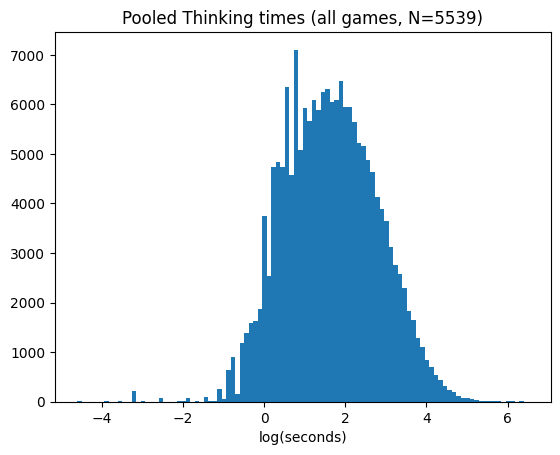

In [6]:
plt.hist(all_move_times, bins=100)
plt.title(f"Pooled Thinking times (all games, N={len(rapid_games)})")
plt.xlabel("log(seconds)")

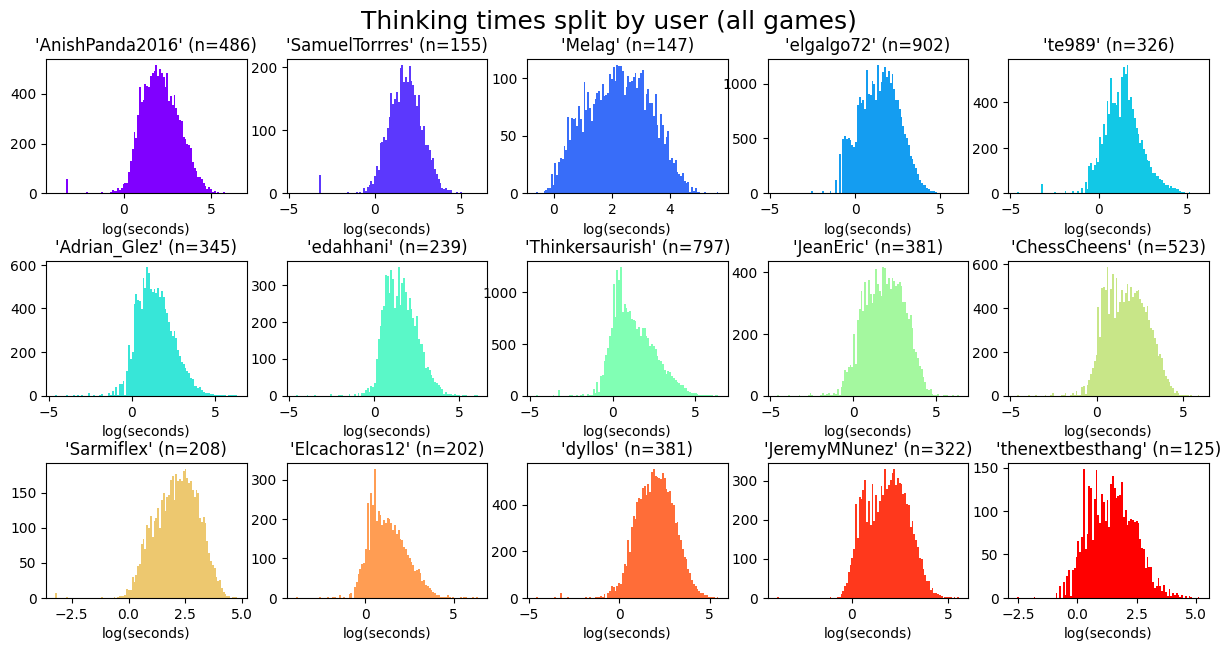

In [7]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (all games)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(rapid_games.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    by_user = rapid_games[rapid_games["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=100, color=next(color))
    ax.set_title(f"'{user}' (n={len(rapid_games[rapid_games["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()


#### Filtered for Games **with** Increment

In [8]:
with_increment = rapid_games[rapid_games["increment"] != 0]

In [9]:
move_times_increment = list(chain.from_iterable(with_increment["moveTimes"].to_list()))
move_times_increment = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

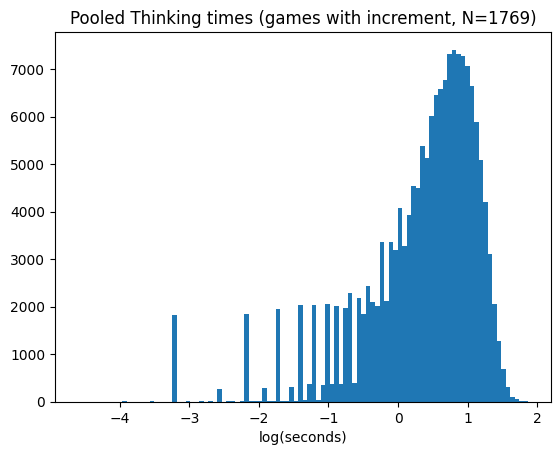

In [10]:
plt.hist(move_times_increment, bins=100)
plt.title(f"Pooled Thinking times (games with increment, N={len(with_increment)})")
plt.xlabel("log(seconds)")

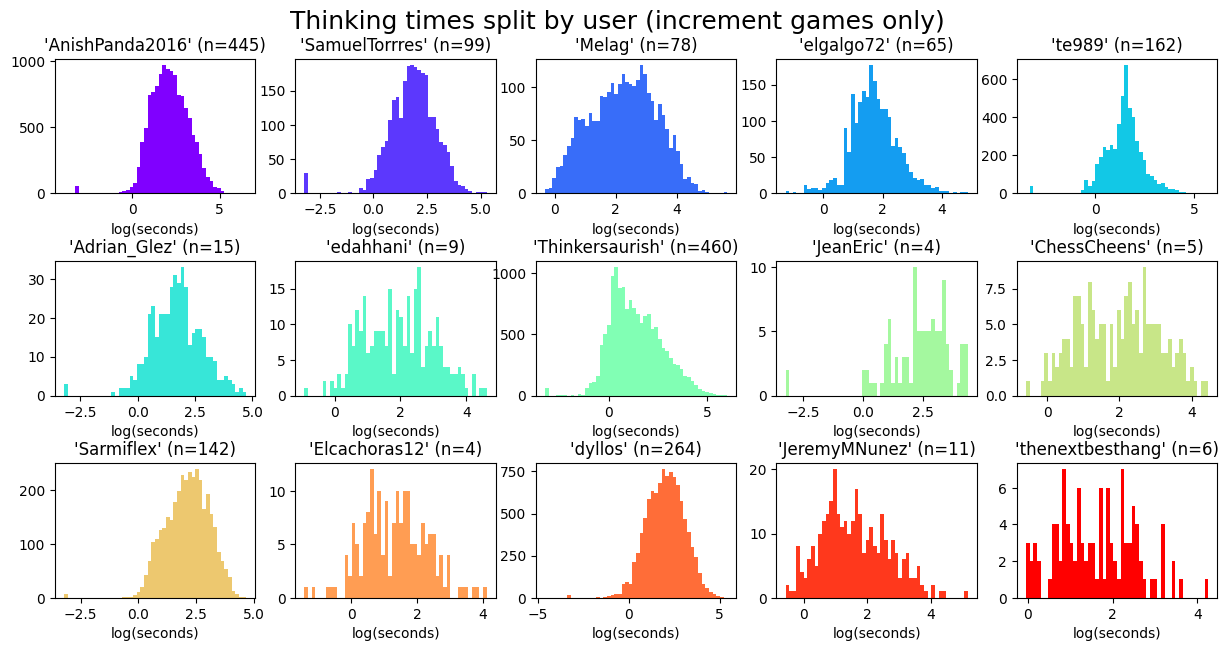

In [11]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (increment games only)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(with_increment.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(with_increment.username.unique(), axs.ravel()):
    by_user = with_increment[with_increment["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=50, color=next(color))
    ax.set_title(f"'{user}' (n={len(with_increment[with_increment["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()

## Activity per user

In [12]:
for i in range(len(rapid_games)):
    for j in range(len(ratings)):
        if rapid_games.loc[i,"dateCreated"] == ratings.loc[j, "date"] and rapid_games.loc[i,"username"] == ratings.loc[j, "username"]:
            rapid_games.loc[i, "ratingOnDay"] = ratings.loc[j,"rating"]

In [13]:
# Define the mapping
outcome_mapping = {"win": 1, "draw": 0.5, "loss": 0}

# Apply the mapping to create a new numeric column
rapid_games["outcome_numeric"] = rapid_games["outcome"].map(outcome_mapping).astype("float")

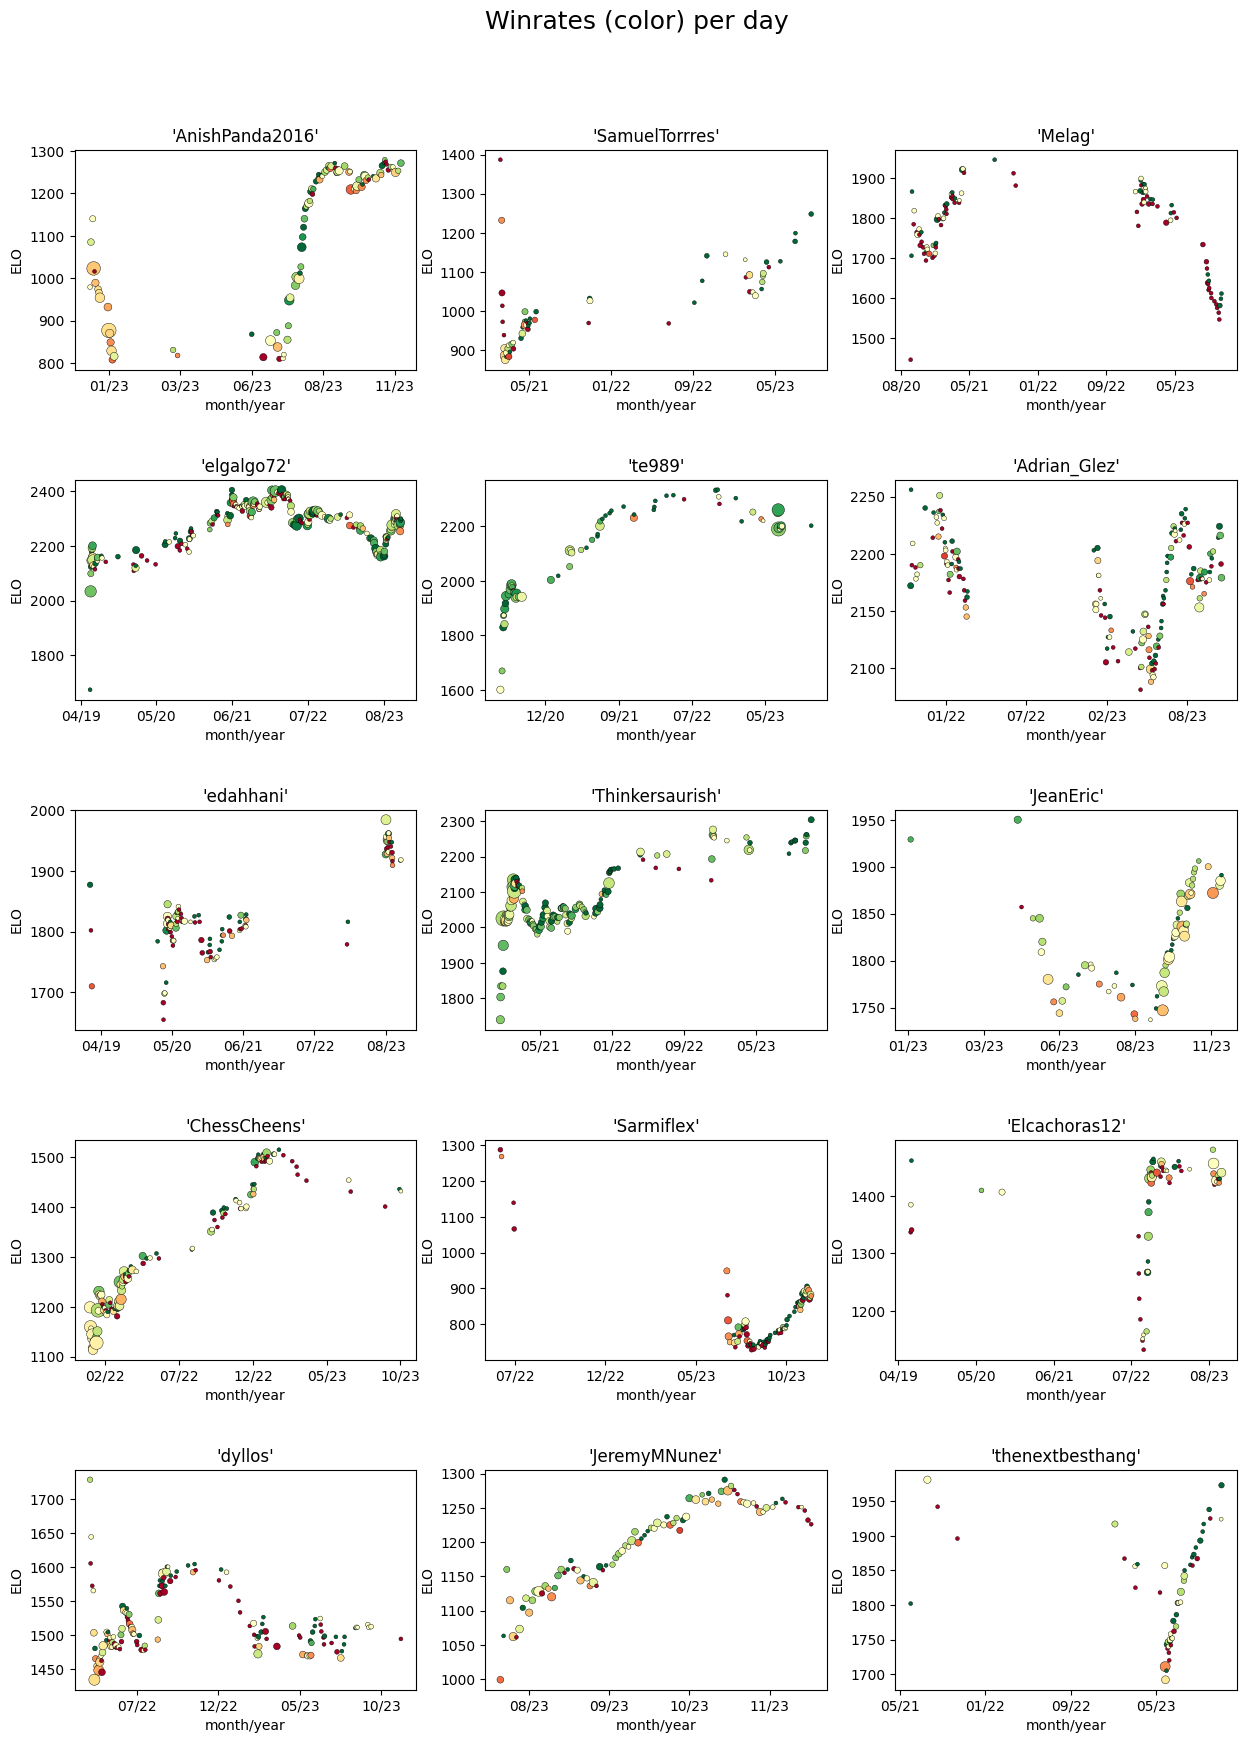

In [14]:
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Winrates (color) per day", fontsize=18, y=0.95)
plt.title("size indicates number of games played, color indicates win percentage.", fontsize=10, y=1)
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    games_by_user = rapid_games[rapid_games["username"]==user].groupby("dateCreated")
    percentage_won = games_by_user["outcome_numeric"].mean()
    ax.scatter(
        games_by_user["ratingOnDay"].count().index, 
        games_by_user["ratingOnDay"].mean(), 
        edgecolor='black', 
        linewidth=0.3,
        s=4 + games_by_user["ratingOnDay"].count()*4, 
        c=percentage_won,  # Use percentage of games won for color
        cmap='RdYlGn',   # Choose a colormap
        alpha=1,
    ) 
    ax.set_title(f"'{user}'")
    ax.set_xlabel("month/year")
    ax.set_ylabel("ELO")
    desired_number_of_ticks=5
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=desired_number_of_ticks))
    myFmt = DateFormatter("%m/%y")
    ax.xaxis.set_major_formatter(myFmt)
    #ax.title(f"Games over time for '{user}'")

# Show the plots

plt.show()


## Correlations

### Correlations (all data)

In [15]:
cor_columns = set(rapid_games.columns)
cor_columns.remove("rated")
cor_columns.remove("increment")

cor_matrix = round(rapid_games[["blunders","averaged_cp_loss","ratingOnDay"]].corr(numeric_only=True), 2)
cor_matrix

,blunders,averaged_cp_loss,ratingOnDay
blunders,1.00,0.48,-0.35
averaged_cp_loss,0.48,1.00,-0.35
ratingOnDay,-0.35,-0.35,1.00


### Correlations (averaged for each user)

In [16]:

# clock data:
clock_data = pd.read_csv("../data/rapid_games_clocks.csv")

In [17]:
clock_data["analysed"] = clock_data["analysis"].apply(lambda x: 0 if pd.isna(x) else 1)


In [18]:
averages = ratings.groupby("username").mean("rating")
averages["games_played"] = rapid_games.groupby("username").count()["id"]
averages["games_analysed"] = clock_data.groupby("username")["analysed"].sum()
averages["avg_cp_loss/game"] = rapid_games.groupby("username")["averaged_cp_loss"].mean()
averages["avg_blunders/game"] = rapid_games.groupby("username")["blunders"].mean()
averages["puzzle_rating"] = puzzles.groupby("username")["rating"].mean()

round(averages.corr(),2)

C:\Users\phili\AppData\Local\Temp\ipykernel_28632\2567610693.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averages["games_played"] = rapid_games.groupby("username").count()["id"]
C:\Users\phili\AppData\Local\Temp\ipykernel_28632\2567610693.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averages["avg_cp_loss/game"] = rapid_games.groupby("username")["averaged_cp_loss"].mean()
C:\Users\phili\AppData\Local\Temp\ipykernel_28632\2567610693.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

,rating,games_played,games_analysed,avg_cp_loss/game,avg_blunders/game,puzzle_rating
rating,1.00,0.42,0.39,-0.93,-0.86,0.77
games_played,0.42,1.00,0.57,-0.42,-0.34,0.51
games_analysed,0.39,0.57,1.00,-0.40,-0.38,0.58
avg_cp_loss/game,-0.93,-0.42,-0.40,1.00,0.96,-0.80
avg_blunders/game,-0.86,-0.34,-0.38,0.96,1.00,-0.79
puzzle_rating,0.77,0.51,0.58,-0.80,-0.79,1.00


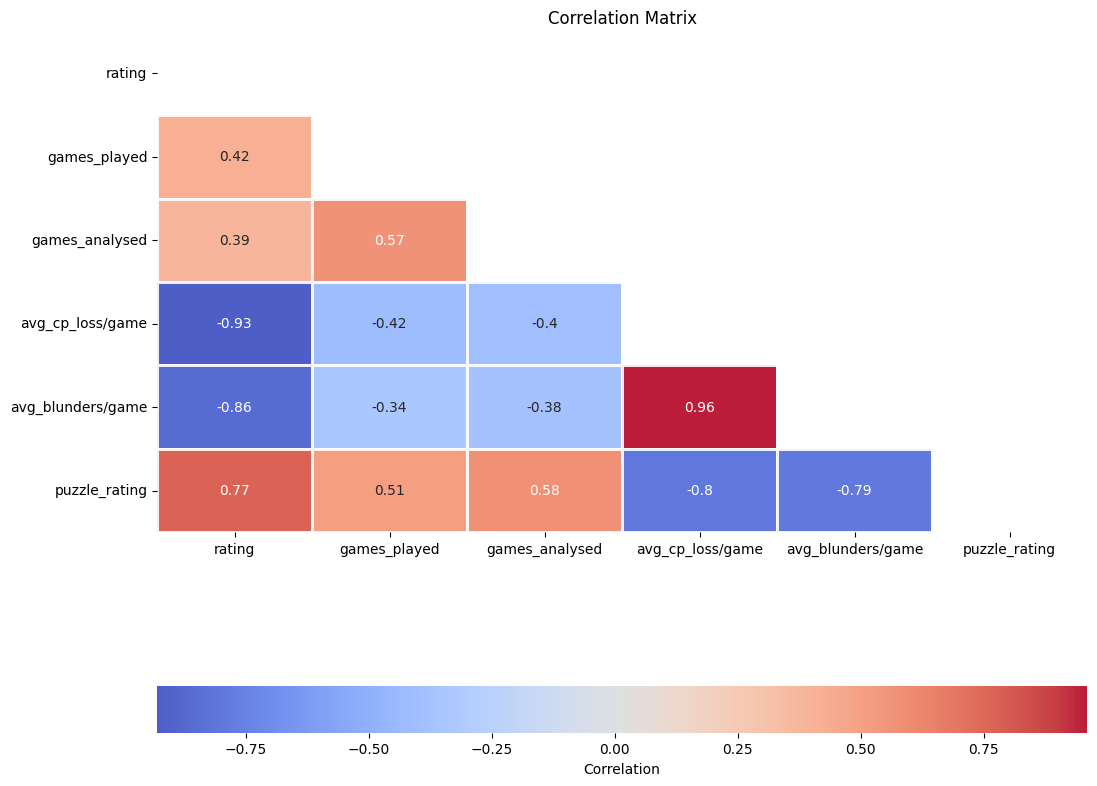

In [19]:
# Create a heatmap using seaborn
mask = np.triu(np.ones_like(round(averages.corr(),2), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    round(averages.corr(),2), 
    annot=True, 
    cmap='coolwarm', 
    linewidths=1, 
    mask=mask, 
    cbar_kws={"orientation": "horizontal", "pad": 0.2, "label": "Correlation"}, 
    alpha=0.9
    )
plt.title('Correlation Matrix')
plt.show()

## Linear Regressions

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2670.753909,122.159311,21.862876,1.231271e-11,0.868414,0.858292,2406.844761,2934.663056
1,avg_cp_loss/game,-16.627935,1.795184,-9.262525,4.343485e-07,0.868414,0.858292,-20.506193,-12.749676


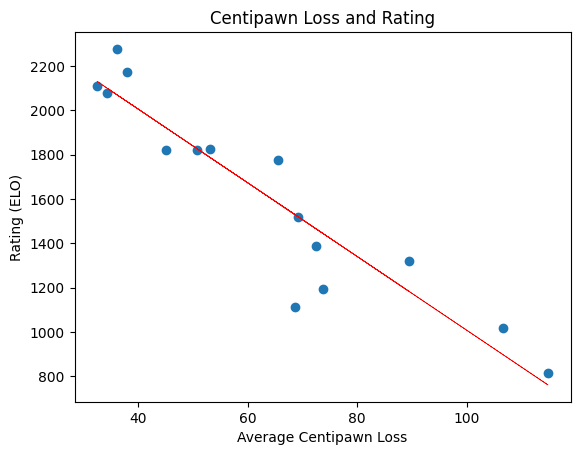

In [20]:
plt.scatter(averages["avg_cp_loss/game"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["avg_cp_loss/game"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]

plt.plot(averages["avg_cp_loss/game"], a*averages["avg_cp_loss/game"]+b, color="red", linewidth=0.5)

plt.title("Centipawn Loss and Rating")
plt.xlabel("Average Centipawn Loss")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2605.243532,171.069737,15.229132,1.144873e-09,0.746906,0.727438,2235.669835,2974.817229
1,avg_blunders/game,-353.946594,57.144384,-6.193900,3.250481e-05,0.746906,0.727438,-477.399531,-230.493657


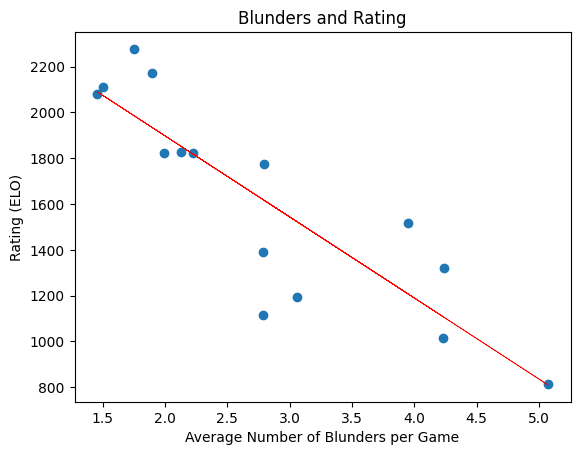

In [21]:
plt.scatter(averages["avg_blunders/game"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["avg_blunders/game"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["avg_blunders/game"], a*averages["avg_blunders/game"]+b, color="red", linewidth=0.5)

plt.title("Blunders and Rating")
plt.xlabel("Average Number of Blunders per Game")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1307.909410,216.917997,6.029511,0.000042,0.175281,0.111841,839.286569,1776.532251
1,games_played,0.837495,0.503844,1.662211,0.120380,0.175281,0.111841,-0.250994,1.925983


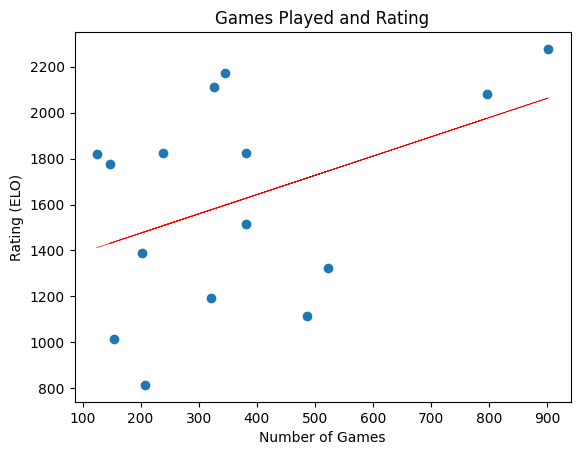

In [22]:
plt.scatter(averages["games_played"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["games_played"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["games_played"], a*averages["games_played"]+b, color="red", linewidth=0.5)

plt.title("Games Played and Rating")
plt.xlabel("Number of Games")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-125.328724,382.142897,-0.327963,0.747473,0.586995,0.559461,-939.847028,689.189579
1,puzzle_rating,0.996651,0.215853,4.617267,0.000335,0.586995,0.559461,0.536571,1.456731


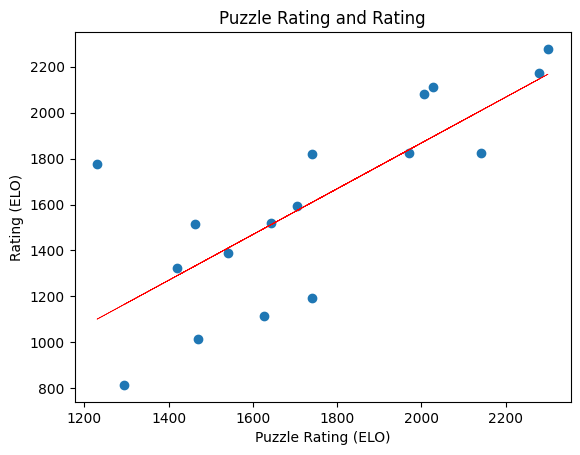

In [23]:
plt.scatter(averages["puzzle_rating"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["puzzle_rating"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["puzzle_rating"], a*averages["puzzle_rating"]+b, color="red", linewidth=0.5)

plt.title("Puzzle Rating and Rating")
plt.xlabel("Puzzle Rating (ELO)")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1457.179427,153.585061,9.487768,3.300065e-07,0.153866,0.088779,1125.379075,1788.979779
1,games_analysed,1.916799,1.246675,1.537530,1.481406e-01,0.153866,0.088779,-0.776478,4.610076


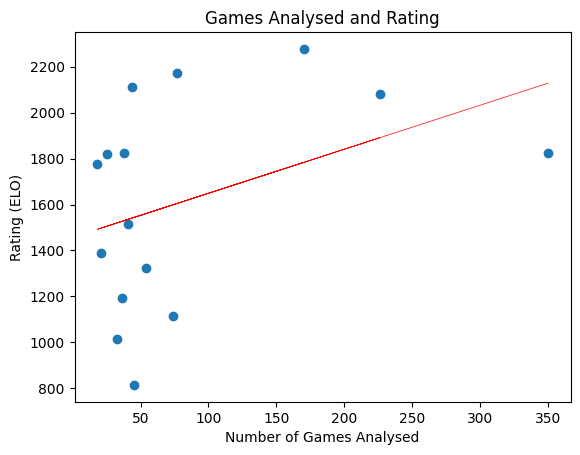

In [24]:
plt.scatter(averages["games_analysed"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["games_analysed"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["games_analysed"], a*averages["games_analysed"]+b, color="red", linewidth=0.5)

plt.title("Games Analysed and Rating")
plt.xlabel("Number of Games Analysed")
plt.ylabel("Rating (ELO)")

fit

## Vector Auto Regression (VAR)